In [1]:
import cv2
import mediapipe as mp
import numpy as np
from matplotlib import pyplot as plt
from functions_pose_estimation import find_local_minimum, \
    impact_points_plot, euclidean_distance, overstride_plot, \
    angle_between, angle_plot, retrieve_matrix

# Preprocessing notes:

0. warm up and exclude that portion of the video for running form
1. video should keep proportions
2. shift of the tradmill does not impact angles and relative positions but absolute positions
3. frontal view needed for 3d and more detailed approaches
    - Simmetry respect to central axis
    - oscillations
    - elbows and shoulders positions
4. metrics to check:
    -  Elbow angle
    -  heel strike (angle at which foot touches the ground)
    - oversitriding - center of foot should fall below center of body projection
5. run at two different speeds to check degradation/improvement of running form
6. other considerations about running cadence can be done retrieving frequency
7. same algo can be applied to bike fitting


In [2]:
# Initialize MediaPipe Pose and Drawing utilities
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose()

# Open the video file
cap = cv2.VideoCapture('IMG_8190.mov')

# frames
START_FRAME = 100  # first frames to skip
MAX_FRAMES = START_FRAME + 500  # frames to consider after skipped ones

# CONSTANTS (cm)
FOOT_SIZE = 26

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
"""
Needed for:
    1. elbow angle: triangle 11 left_shoulder, 13 left_elbow, 15 left wrist
    2. overstriding:
        center of foot (31 left_foot_index - 29 left_heel)
        relative to x projection of hip 23 left_hip
"""

points_to_track = [
    'left_shoulder', 'left_elbow', 'left_wrist',  # elbow triangle
    'left_hip', 'left_foot_index', 'left_heel'  # overstriding
]

coordinates_to_track = {}
for point in points_to_track:
    coordinates_to_track[point] = {'x':[], 'y':[]}

results = []

In [4]:
## Setup mediapipe instance

frame_counter = 0
while cap.isOpened():
    if frame_counter > MAX_FRAMES:
        break

    frame_counter += 1
    ret, frame = cap.read()

    if frame_counter > START_FRAME:        
        if not ret:
            break
        
        # Recolor image to RGB -> mediapipe needs rgb while opencv needs gbr
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        result = pose.process(image)
    
        
        # Draw the pose landmarks on the frame
        if result.pose_landmarks:
            mp_drawing.draw_landmarks(frame, result.pose_landmarks, mp_pose.POSE_CONNECTIONS)
            results.append(result)
        
            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            
            # Render detections
            mp_drawing.draw_landmarks(image, result.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                    mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                    mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                     )               
            
            cv2.imshow('Mediapipe Feed', image)
        
    
        for point in coordinates_to_track.keys():
            try:
                x = result.pose_landmarks.landmark[mp_pose.PoseLandmark[point.upper()].value].x
                y = result.pose_landmarks.landmark[mp_pose.PoseLandmark[point.upper()].value].y
                coordinates_to_track[point]['x'].append(x)
                coordinates_to_track[point]['y'].append(y)
            except:
                pass
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)  # otherwise window doesn't close on macbook

-1

# Impact points

Finding here idx of impacts and mid foot absolute position during impact

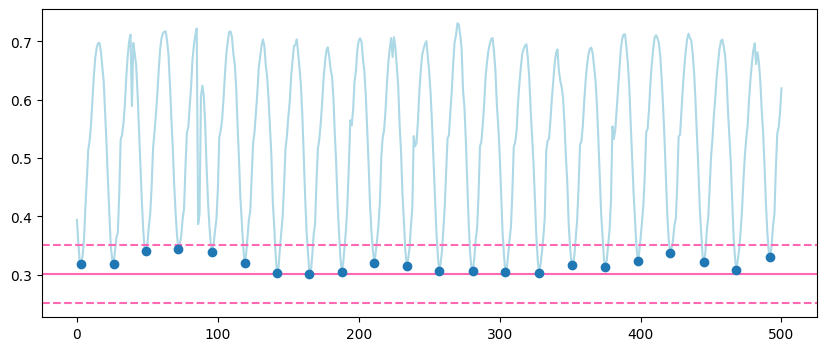

In [5]:
mid_foot_x = \
    np.array(coordinates_to_track['left_foot_index']['x']) + \
    np.array(coordinates_to_track['left_heel']['x'])
mid_foot_x /= 2

# impact points
idx_impact, mid_foot_at_impact = find_local_minimum(mid_foot_x,
                                                    (min(mid_foot_x) + 0.05, min(mid_foot_x) - 0.05))

# local minima are impact points
impact_points_plot(mid_foot_x, idx_impact, mid_foot_at_impact)

# Overstride @ impact point

Using pre-retrieved impact indexes and mid foot absolute positions, finding relative displacement regarding to the left hip. To get it in centimeters, a proportion is applied. It appears clearly a slight tendency to oversitride

In [6]:
# finding foot absolute size in the square
heel = coordinates_to_track['left_heel']['x'][0], coordinates_to_track['left_heel']['y'][0]
foot_idx = coordinates_to_track['left_foot_index']['x'][0], coordinates_to_track['left_foot_index']['y'][0]

# proportion factor in cm
proportion_factor = FOOT_SIZE/euclidean_distance(heel, foot_idx)

In [7]:
# finding displacement
left_hip_x = np.array(coordinates_to_track['left_hip']['x'])
left_hip_x = left_hip_x[idx_impact]
displacement_foot_hip =  proportion_factor * (left_hip_x - mid_foot_at_impact)

In [8]:
# confidence interval (in cm)
q = [0.05, 0.5, 0.95]
np.round(np.quantile(displacement_foot_hip, q), 1)

array([23.5, 25.9, 27.4])

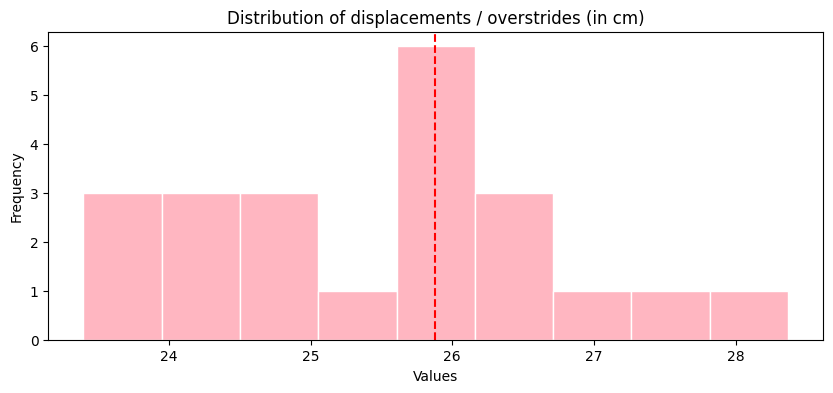

In [9]:
overstride_plot(displacement_foot_hip)

# Foot angle @ impact point
The angle at which the foot touches the ground is $\alpha$, where $\alpha$ is the angle included between heel_foot_vector and the vector [-1, 0]: retrieved using a geometric property of the cross product

In [10]:
# finding angle of the foot at every impact, finding geometric representation
heel = retrieve_matrix(coordinates_to_track, 'left_heel', filter=idx_impact)
foot = retrieve_matrix(coordinates_to_track, 'left_foot_index', filter=idx_impact)

In [11]:
# angles calculations
landing_angles = []
for idx in range(len(foot)):
    heel_foot_vector = foot[idx] - heel[idx]
    landing_angles.append(angle_between(heel_foot_vector, [-1, 0]))

# confidence interval (in degrees)
q = [0.05, 0.5, 0.95]
np.round(np.quantile(landing_angles, q), 1)

array([ 2.2,  7.9, 11. ])

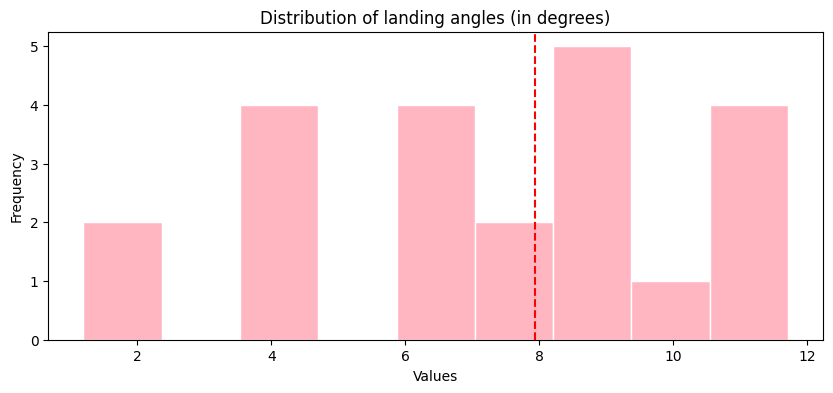

In [12]:
angle_plot(landing_angles, "Distribution of landing angles (in degrees)")

# Elbow angle
Similar approach as the landing angle, this time the angle is between wrist - elbow - shoulder (not just on landing)

In [13]:
# finding angle of the foot at every impact, finding geometric representation
wrist = retrieve_matrix(coordinates_to_track, 'left_wrist')
elbow = retrieve_matrix(coordinates_to_track, 'left_elbow')
shoulder = retrieve_matrix(coordinates_to_track, 'left_shoulder')

In [14]:
# angles calculations
elbow_angles = []
for idx in range(len(wrist)):
    elbow_shoulder_vector = shoulder[idx] - elbow[idx]
    elbow_wrist_vector = wrist[idx] - elbow[idx]    
    elbow_angles.append(angle_between(elbow_shoulder_vector, elbow_wrist_vector))

# confidence interval (in degrees)
q = [0.05, 0.5, 0.95]
np.round(np.quantile(elbow_angles, q), 1)

array([56.3, 74.1, 89. ])

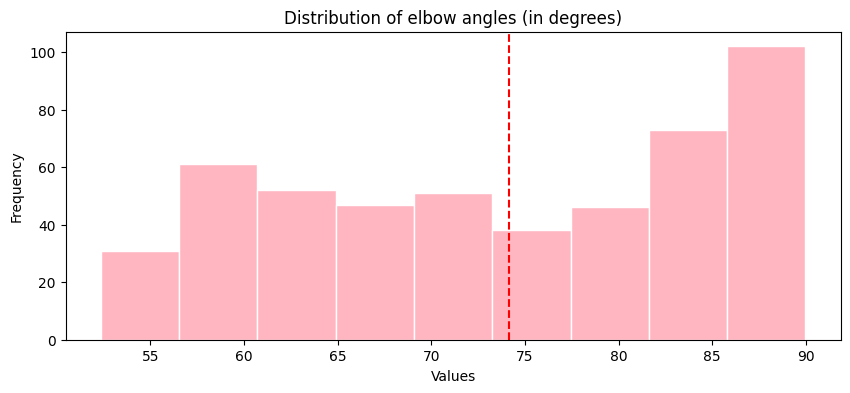

In [15]:
angle_plot(elbow_angles, "Distribution of elbow angles (in degrees)")